In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer

In [2]:
import os
import numpy as np

import warnings

import sklearn.linear_model
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

x_train_df = pd.read_csv('../data/data_reviews/x_train.csv')
y_train_df = pd.read_csv('../data/data_reviews/y_train.csv')
x_test_df = pd.read_csv('../data/data_reviews/x_test.csv')

In [3]:
x_train = x_train_df['text'] 
x_test = x_test_df['text']
x_train

0       Oh and I forgot to also mention the weird colo...
1                            THAT one didn't work either.
2                                      Waste of 13 bucks.
3       Product is useless, since it does not have eno...
4       None of the three sizes they sent with the hea...
                              ...                        
2395    The sweet potato fries were very good and seas...
2396    I could eat their bruschetta all day it is dev...
2397                                 Ambience is perfect.
2398    We ordered the duck rare and it was pink and t...
2399         Service was good and the company was better!
Name: text, Length: 2400, dtype: object

In [4]:
amazon_i = np.where(x_train_df['website_name']=='amazon')
imdb_i = np.where(x_train_df['website_name']=='imdb')
yelp_i =  np.where(x_train_df['website_name']=='yelp')

In [20]:
import pandas as pd
import numpy as np
import sklearn.neighbors

from collections import OrderedDict

word_embeddings = pd.read_csv('../data/pretrained_word_embeddings/glove.6B.50d.txt.zip',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, compression='zip', encoding='utf-8', quoting=3)
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

## Show some examples

n_words = len(word2vec.keys())
print("word2vec['happy'] = ")
print(word2vec['happy'])

## Try some analogies
def analogy_lookup(a1, a2, b1):
    target_vec = word2vec[a2] - word2vec[a1] + word2vec[b1]
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=7, metric='euclidean', algorithm='brute')
    knn.fit(word_embeddings.values)
    dists, indices = knn.kneighbors(target_vec[np.newaxis,:])
    print("Query: %s:%s -> %s:____" % (a1, a2, b1))
    for ii, vv in enumerate(indices[0]):
        print("   %20s  at dist %.3f" % (word_list[vv], dists[0,ii]))

analogy_lookup('movie', 'film', 'theater')

word2vec['happy'] = 
[ 0.092086  0.2571   -0.58693  -0.37029   1.0828   -0.55466  -0.78142
  0.58696  -0.58714   0.46318  -0.11267   0.2606   -0.26928  -0.072466
  1.247     0.30571   0.56731   0.30509  -0.050312 -0.64443  -0.54513
  0.86429   0.20914   0.56334   1.1228   -1.0516   -0.78105   0.29656
  0.7261   -0.61392   2.4225    1.0142   -0.17753   0.4147   -0.12966
 -0.47064   0.3807    0.16309  -0.323    -0.77899  -0.42473  -0.30826
 -0.42242   0.055069  0.38267   0.037415 -0.4302   -0.39442   0.10511
  0.87286 ]
Query: movie:film -> theater:____
                theatre  at dist 1.977
                theater  at dist 2.158
                 cinema  at dist 3.639
                  opera  at dist 3.654
                 ballet  at dist 3.729
               ensemble  at dist 3.817
                 studio  at dist 3.967


## Preprocess

In [5]:
pip install autocorrect

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [7]:
from autocorrect import Speller
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
porterstemmer = PorterStemmer()
wnl = WordNetLemmatizer()
spell = Speller()

common_words = pd.read_csv('../data/data_reviews/modified_stopword.txt')

In [14]:
stop_words = common_words['words']
test_stop_words = pd.Series(stop_words).array

In [15]:
import re

def simple_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()   
    return words

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def stemming_tokenizer(str_input):
    words = decontracted(str_input)
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()
    
    # autocorrect
    test_names = words
    test_names_len = len(words)
    words = [spell(test_names[i]) for i in range(test_names_len)]

    # prune words
#     def prune_food(w):
#         if w == 'bones' or w == 'bone' or w == 'fish' or w == 'worms' or w == 'worm':
#             w = 'food'
#         return w
    
#     words = [prune_food(word) for word in words]
    
    # stemming 
#     porter_stemmer = PorterStemmer()
#     words = [porter_stemmer.stem(word) for word in words]
    
    #remove non important words
#     non_important = ['film', 'movie','apple', 'juice']
#     words = [w for w in words if w not in non_important]
    
    stop_words = common_words['words']
    stop_words = pd.Series(stop_words).array
    words = [w for w in words if w not in stop_words]
    
    return words

In [16]:
words = [stemming_tokenizer(x_train[i]) for i in range(len(x_train))]

flat_list = sum(words, [])
len(flat_list)

flat_list

['oh',
 'forgot',
 'to',
 'also',
 'mention',
 'weird',
 'color',
 'effect',
 'on',
 'phone',
 'one',
 'didn',
 't',
 'work',
 'either',
 'waste',
 'of',
 'bucks',
 'product',
 'useless',
 'since',
 'not',
 'enough',
 'charging',
 'current',
 'to',
 'charge',
 'cellphone',
 'planning',
 'to',
 'use',
 'with',
 'none',
 'of',
 'three',
 'sizes',
 'sent',
 'with',
 'headset',
 'would',
 'stay',
 'in',
 'ears',
 'worst',
 'customer',
 'service',
 'engage',
 'still',
 'lacking',
 'in',
 'earbuds',
 'always',
 'cuts',
 'out',
 'makes',
 'sound',
 'then',
 'says',
 'signal',
 'failed',
 'only',
 'very',
 'disappointing',
 'thing',
 'there',
 'no',
 'speakerphone',
 'very',
 'disappointed',
 'in',
 'accessoryone',
 'basically',
 'service',
 'very',
 'bad',
 'bad',
 'choice',
 'only',
 'thing',
 'disappoint',
 'infra',
 'red',
 'port',
 'rida',
 'horrible',
 'to',
 'switch',
 'times',
 'feels',
 'poorly',
 'constructed',
 'menus',
 'difficult',
 'to',
 'navigate',
 'buttons',
 'so',
 'recessed

In [17]:
len(flat_list)

20160

In [18]:
words_te = [stemming_tokenizer(x_test[i]) for i in range(len(x_test))]

flat_list_te = sum(words_te, [])
len(flat_list_te)

5000

## Taking the Average

In [21]:
keys = word2vec.keys()

In [22]:
x_tr = []

for x in range(len(words)):
    filtered_init = []
    for i in range(len(words[x])):
        if (words[x][i] in keys):
            filtered_init.append(words[x][i])
            filtered = set(filtered_init)
        t = [word2vec[w].reshape(50) for w in filtered]
    x_tr.append(np.average(t, axis=0))

# x = np.array(x_tr)
x_tr

[array([ 0.17039013,  0.316874  ,  0.0769251 ,  0.024993  ,  0.2336751 ,
         0.0097701 , -0.2780699 , -0.1513718 , -0.2345509 ,  0.2776064 ,
        -0.0436095 ,  0.2246413 , -0.0406724 ,  0.009267  ,  0.4785861 ,
         0.3444467 , -0.402169  , -0.1542593 , -0.090973  , -0.3679115 ,
         0.1105163 ,  0.1681814 ,  0.4869354 ,  0.100755  ,  0.3127284 ,
        -1.3446656 , -0.7357431 ,  0.3157422 ,  0.5164237 , -0.52233   ,
         2.47548   ,  0.17911044, -0.2674899 , -0.306926  ,  0.02842028,
        -0.1377787 ,  0.2188867 ,  0.0093702 , -0.0819997 , -0.0436157 ,
         0.1075786 ,  0.297531  , -0.191514  ,  0.0618058 ,  0.0225586 ,
         0.0974955 ,  0.03822657,  0.0187831 ,  0.09164388,  0.1959433 ]),
 array([ 0.1615816 ,  0.187342  ,  0.390088  , -0.070598  ,  0.2066448 ,
         0.0072564 , -0.164818  , -0.2787924 , -0.23759284, -0.0580208 ,
         0.0564448 ,  0.355628  , -0.5281052 , -0.251774  ,  0.2497166 ,
         0.12228   , -0.1998096 ,  0.080416  ,  0

In [23]:
x_te = []

for x in range(len(words_te)):
    filtered_init = []
    for i in range(len(words_te[x])):
        if (words_te[x][i] in keys):
            filtered_init.append(words_te[x][i])
            filtered = set(filtered_init)
        t = [word2vec[w].reshape(50) for w in filtered]
    x_te.append(np.average(t, axis=0))

x_test = np.array(x_te)

# Prepare X,y #

In [25]:
X = np.array(x_tr)
y = y_train_df['is_positive_sentiment'].to_numpy()
feat_num = X.shape[1]

In [26]:
import sklearn.metrics

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

# SVM

In [27]:
import numpy as np

from sklearn.datasets import make_blobs, make_circles
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import seaborn as sns; sns.set()

### CV without the best C

#### rbf

In [28]:
print("-----------------\nClassify with base data, 5 folds\n-----------------")

k = 3
kfold = KFold(n_splits=k)
train_scores = []
test_scores = []
model = SVC(kernel='rbf')

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    print("Train score: ", score_train)
    print("Test score: ", score_test)
    
    train_scores.append(score_train)
    test_scores.append(score_test)
    
print("\nAverage train accuracy: ", np.average(score_train))
print("Average test accuracy: ", np.average(score_test))

-----------------
Classify with base data, 5 folds
-----------------
Train score:  0.8025
Test score:  0.75875
Train score:  0.813125
Test score:  0.755
Train score:  0.79625
Test score:  0.77

Average train accuracy:  0.79625
Average test accuracy:  0.77


#### linear

In [29]:
print("-----------------\nClassify with base data, 5 folds\n-----------------")

k = 3
kfold = KFold(n_splits=k)
train_scores = []
test_scores = []
model = SVC(kernel='linear')

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    print("Train score: ", score_train)
    print("Test score: ", score_test)
    
    train_scores.append(score_train)
    test_scores.append(score_test)
    
print("\nAverage train accuracy: ", np.average(score_train))
print("Average test accuracy: ", np.average(score_test))

-----------------
Classify with base data, 5 folds
-----------------
Train score:  0.785625
Test score:  0.76125
Train score:  0.7975
Test score:  0.74125
Train score:  0.77375
Test score:  0.7525

Average train accuracy:  0.77375
Average test accuracy:  0.7525


#### sigmoid

In [30]:
print("-----------------\nClassify with base data, 5 folds\n-----------------")

k = 3
kfold = KFold(n_splits=k)
train_scores = []
test_scores = []
model = SVC(kernel='sigmoid')

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    print("Train score: ", score_train)
    print("Test score: ", score_test)
    
    train_scores.append(score_train)
    test_scores.append(score_test)
    
print("\nAverage train accuracy: ", np.average(score_train))
print("Average test accuracy: ", np.average(score_test))

-----------------
Classify with base data, 5 folds
-----------------
Train score:  0.74
Test score:  0.70125
Train score:  0.73125
Test score:  0.72875
Train score:  0.760625
Test score:  0.7425

Average train accuracy:  0.760625
Average test accuracy:  0.7425


### CV with the best C

#### c and gamma

In [40]:
# C_range = np.logspace(1/5, 0.9/4, 20)
C_range = np.logspace(-1, 9, 30)
gamma_range = np.logspace(-9, 3, 5)
model_list = []
aver_train_scoreC = []
aver_test_scoreC = []
aver_train_lossC = []
aver_test_lossC = []


for C in C_range:
    for g in gamma_range:
        k = 3
        kfold = KFold(n_splits=k)

        train_scores = []
        test_scores = []
        train_loss = []
        test_loss = []

        model = SVC(kernel='rbf', C=C, gamma=g,probability=True)
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X[train_idx,:], X[test_idx,:]
            y_train, y_test = y[train_idx], y[test_idx]


            model.fit(X_train, y_train)
            pred_train = model.predict_proba(X_train)
            pred_test = model.predict_proba(X_test)

            # Score
            score_train = model.score(X_train, y_train)
            score_test = model.score(X_test, y_test)
    #         print("Train score: ", score_train)
    #         print("Test score: ", score_test)
            train_scores.append(score_train)
            test_scores.append(score_test)

            # Log loss
            log_loss_train = sklearn.metrics.log_loss(y_train,pred_train)
            log_loss_test = sklearn.metrics.log_loss(y_test,pred_test)
    #         print("Train loss: ", log_loss_train)
    #         print("Test loss: ", log_loss_test)
            train_loss.append(log_loss_train)
            test_loss.append(log_loss_test)


        print("\nFor C value : ", C)
        print("\nFor C value : ", g)
        
        print("\nAverage train accuracy: ", np.average(score_train))
        print("Average test accuracy: ", np.average(score_test))
        print("\nAverage train loss: ", np.average(train_loss))
        print("Average test loss: ", np.average(test_loss))

        print('------------------------------------------------\n')

        model_list.append(model)
        aver_train_scoreC.append(np.average(score_train))
        aver_test_scoreC.append(np.average(score_test))
        aver_train_lossC.append(np.average(train_loss))
        aver_test_lossC.append(np.average(test_loss))


For C value :  0.1

For C value :  1e-09

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.6932208897045765
Average test loss:  0.6932208895193895
------------------------------------------------


For C value :  0.1

For C value :  1e-06

Average train accuracy:  0.74625
Average test accuracy:  0.76

Average train loss:  0.6931471805599451
Average test loss:  0.6931471805599451
------------------------------------------------


For C value :  0.1

For C value :  0.001

Average train accuracy:  0.74125
Average test accuracy:  0.745

Average train loss:  0.6935377411544419
Average test loss:  0.6937158636111048
------------------------------------------------


For C value :  0.1

For C value :  1.0

Average train accuracy:  0.69375
Average test accuracy:  0.62625

Average train loss:  0.5317755968741081
Average test loss:  0.6366253178746546
------------------------------------------------


For C value :  0.1

For C value :  1000.0

Average train accur


For C value :  11.721022975334806

For C value :  1000.0

Average train accuracy:  1.0
Average test accuracy:  0.5025

Average train loss:  0.03744515938441224
Average test loss:  0.6925984068837107
------------------------------------------------


For C value :  25.92943797404667

For C value :  1e-09

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.6931712358672454
Average test loss:  0.6931712345290538
------------------------------------------------


For C value :  25.92943797404667

For C value :  1e-06

Average train accuracy:  0.74625
Average test accuracy:  0.76

Average train loss:  0.6931471805599451
Average test loss:  0.6931471805599451
------------------------------------------------


For C value :  25.92943797404667

For C value :  0.001

Average train accuracy:  0.77375
Average test accuracy:  0.775

Average train loss:  0.47570193436900543
Average test loss:  0.5057213373036499
------------------------------------------------


For C


For C value :  3039.195382313201

For C value :  0.001

Average train accuracy:  0.783125
Average test accuracy:  0.76125

Average train loss:  0.4456185747025699
Average test loss:  0.501952769720145
------------------------------------------------


For C value :  3039.195382313201

For C value :  1.0

Average train accuracy:  1.0
Average test accuracy:  0.71125

Average train loss:  0.0836985702818525
Average test loss:  0.6208332801218052
------------------------------------------------


For C value :  3039.195382313201

For C value :  1000.0

Average train accuracy:  1.0
Average test accuracy:  0.5025

Average train loss:  0.04468599519829833
Average test loss:  0.6923732666038805
------------------------------------------------


For C value :  6723.357536499335

For C value :  1e-09

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.6931471805599451
Average test loss:  0.6931471805599451
------------------------------------------------


For C va


For C value :  788046.281566992

For C value :  1e-09

Average train accuracy:  0.511875
Average test accuracy:  0.505

Average train loss:  0.6776700469092122
Average test loss:  0.680707290324784
------------------------------------------------


For C value :  788046.281566992

For C value :  1e-06

Average train accuracy:  0.774375
Average test accuracy:  0.7525

Average train loss:  0.46660457064796357
Average test loss:  0.5104965563731338
------------------------------------------------


For C value :  788046.281566992

For C value :  0.001

Average train accuracy:  0.93875
Average test accuracy:  0.7025

Average train loss:  0.3675988348454618
Average test loss:  0.6333205061387363
------------------------------------------------


For C value :  788046.281566992

For C value :  1.0

Average train accuracy:  1.0
Average test accuracy:  0.71125

Average train loss:  0.08914816984552058
Average test loss:  0.6212329777587796
------------------------------------------------


Fo


For C value :  92367085.71873884

For C value :  1.0

Average train accuracy:  1.0
Average test accuracy:  0.71125

Average train loss:  0.08511804158597176
Average test loss:  0.6210239535909422
------------------------------------------------


For C value :  92367085.71873884

For C value :  1000.0

Average train accuracy:  1.0
Average test accuracy:  0.5025

Average train loss:  0.022935094405104117
Average test loss:  0.6924404366722873
------------------------------------------------


For C value :  204335971.7856948

For C value :  1e-09

Average train accuracy:  0.50125
Average test accuracy:  0.50625

Average train loss:  1.6451984445303227
Average test loss:  1.5384699530891517
------------------------------------------------


For C value :  204335971.7856948

For C value :  1e-06

Average train accuracy:  0.769375
Average test accuracy:  0.7675

Average train loss:  0.47502341649504953
Average test loss:  0.5122831705265404
------------------------------------------------

#### just C

In [43]:
# C_range = np.logspace(1/5, 0.9/4, 20)
C_range = np.logspace(-1, 9, 30)
# gamma_range = np.logspace(-9, 3, 5)
model_list = []
aver_train_scoreC = []
aver_test_scoreC = []
aver_train_lossC = []
aver_test_lossC = []


for C in C_range:
    k = 3
    kfold = KFold(n_splits=k)

    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []

    model = SVC(kernel='rbf', C=C, probability=True)
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx,:], X[test_idx,:]
        y_train, y_test = y[train_idx], y[test_idx]


        model.fit(X_train, y_train)
        pred_train = model.predict_proba(X_train)
        pred_test = model.predict_proba(X_test)

        # Score
        score_train = model.score(X_train, y_train)
        score_test = model.score(X_test, y_test)
#         print("Train score: ", score_train)
#         print("Test score: ", score_test)
        train_scores.append(score_train)
        test_scores.append(score_test)

        # Log loss
        log_loss_train = sklearn.metrics.log_loss(y_train,pred_train)
        log_loss_test = sklearn.metrics.log_loss(y_test,pred_test)
#         print("Train loss: ", log_loss_train)
#         print("Test loss: ", log_loss_test)
        train_loss.append(log_loss_train)
        test_loss.append(log_loss_test)


    print("\nFor C value : ", C)

    print("\nAverage train accuracy: ", np.average(score_train))
    print("Average test accuracy: ", np.average(score_test))
    print("\nAverage train loss: ", np.average(train_loss))
    print("Average test loss: ", np.average(test_loss))

    print('------------------------------------------------\n')

    model_list.append(model)
    aver_train_scoreC.append(np.average(score_train))
    aver_test_scoreC.append(np.average(score_test))
    aver_train_lossC.append(np.average(train_loss))
    aver_test_lossC.append(np.average(test_loss))


For C value :  0.1

Average train accuracy:  0.7675
Average test accuracy:  0.77125

Average train loss:  0.4943191106972588
Average test loss:  0.5222179555067926
------------------------------------------------


For C value :  0.2212216291070449

Average train accuracy:  0.77875
Average test accuracy:  0.7725

Average train loss:  0.47342758149032904
Average test loss:  0.5122432238092112
------------------------------------------------


For C value :  0.4893900918477494

Average train accuracy:  0.79
Average test accuracy:  0.7725

Average train loss:  0.4524299842242033
Average test loss:  0.5002994446900711
------------------------------------------------


For C value :  1.0826367338740546

Average train accuracy:  0.7975
Average test accuracy:  0.7675

Average train loss:  0.43307236080785355
Average test loss:  0.49568756826938287
------------------------------------------------


For C value :  2.395026619987486

Average train accuracy:  0.810625
Average test accuracy:  0.7

In [44]:
min_loss = min(aver_test_lossC)
index_N2 = aver_test_lossC.index(min_loss)
# best_C =  C_range[index_N2]
# best_model = model_list[index_N2]
min_loss
# index_N2
# best_C

0.4935681158167782

## Accuracy

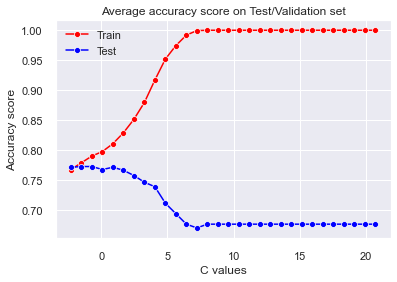

In [48]:
plt.xlabel('C values');
plt.ylabel('Accuracy score');
# plt.ylim([0.0, 1]);

# TODO
# p 
sns.lineplot(x = np.log(C_range), y = aver_train_scoreC, label = "Train", color = "red", marker='o')
sns.lineplot(x = np.log(C_range), y = aver_test_scoreC, label = "Test", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Average accuracy score on Test/Validation set')
plt.show()

# print("Best C-value for LR: %.3f" % best_C) 
# print("Test set log-loss at best C-value: %.4f" % min_loss)

## Log loss

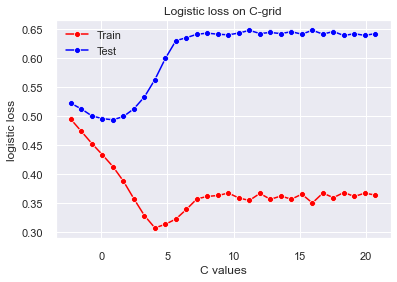

Best C-value for LR: 2.395
Test set log-loss at best C-value: 0.4936


In [47]:
plt.xlabel('C values');
plt.ylabel('logistic loss');
# plt.ylim([0.0, 1]);

# TODO
# p 
sns.lineplot(x = np.log(C_range), y = aver_train_lossC, label = "Train", color = "red", marker='o')
sns.lineplot(x = np.log(C_range), y = aver_test_lossC, label = "Test", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Logistic loss on C-grid')
plt.show()

print("Best C-value for LR: %.3f" % best_C) 
print("Test set log-loss at best C-value: %.4f" % min_loss)

#### with d

In [ ]:
C_range = np.logspace(-1, 10, 5)
gamma_range = np.logspace(-9, 3, 5)
d_range = [2,3,5,8,10]
model_list2 = []
aver_train_score2 = []
aver_test_score2 = []
aver_train_loss2 = []
aver_test_loss2 = []


for C in C_range:
    for g in gamma_range:
        for d in d_range:
            k = 3
            kfold = KFold(n_splits=k)

            train_scores = []
            test_scores = []
            train_loss = []
            test_loss = []

            model = SVC(kernel='rbf', C=C, gamma=g,degree=d)
            for train_idx, test_idx in kfold.split(X):
                X_train, X_test = X[train_idx,:], X[test_idx,:]
                y_train, y_test = y[train_idx], y[test_idx]

                model.fit(X_train, y_train)
                pred_train = model.predict(X_train)
                pred_test = model.predict(X_test)

                # Score
                score_train = model.score(X_train, y_train)
                score_test = model.score(X_test, y_test)
        #         print("Train score: ", score_train)
        #         print("Test score: ", score_test)
                train_scores.append(score_train)
                test_scores.append(score_test)

                # Log loss
                log_loss_train = sklearn.metrics.log_loss(y_train,pred_train)
                log_loss_test = sklearn.metrics.log_loss(y_test,pred_test)
        #         print("Train loss: ", log_loss_train)
        #         print("Test loss: ", log_loss_test)
                train_loss.append(log_loss_train)
                test_loss.append(log_loss_test)


#             print("\nFor C value : ", C)
#             print("\nFor gamma value : ", g)
#             print("\nFor degree : ", d)
            
#             print("\nAverage train accuracy: ", np.average(score_train))
#             print("Average test accuracy: ", np.average(score_test))
#             print("\nAverage train loss: ", np.average(train_loss))
#             print("Average test loss: ", np.average(test_loss))

            print('----\n')

            model_list2.append(model)
            aver_train_score2.append(np.average(score_train))
            aver_test_score2.append(np.average(score_test))
            aver_train_loss2.append(np.average(train_loss))
            aver_test_loss2.append(np.average(test_loss))

#### Best Log loss

In [ ]:
min_loss = min(aver_test_loss)
index_N2 = aver_test_loss.index(min_loss)
# best_C =  C_grid[index_N2]
best_model = model_list[index_N2]

#### stability across Kfolds

In [107]:
print("-----------------\nClassify with base data, 5 folds\n-----------------")

K = [2,3,4,5,8,10]
K_train_loss = []
K_test_loss = []
for k in K:
    kfold = KFold(n_splits=k)
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    
    for train_idx, test_idx in kfold.split(X):
        shuffler = np.random.permutation(len(X))
        X_shuffled = X[shuffler]
        y_shuffled = y[shuffler]
        X_train, X_test = X_shuffled[train_idx,:], X_shuffled[test_idx,:]
        y_train, y_test = y_shuffled[train_idx], y_shuffled[test_idx]

        model.fit(X_train, y_train)
        pred_train = best_model.predict_proba(X_train)
        pred_test = best_model.predict_proba(X_test)

        score_train = best_model.score(X_train, y_train)
        score_test = best_model.score(X_test, y_test)
        train_scores.append(score_train)
        test_scores.append(score_test)
        
        log_loss_train = sklearn.metrics.log_loss(y_train,pred_train)
        log_loss_test = sklearn.metrics.log_loss(y_test,pred_test)
        
        train_loss.append(log_loss_train)
        test_loss.append(log_loss_test)

    print("\nAverage train accuracy: ", np.average(score_train))
    print("Average test accuracy: ", np.average(score_test))
    print("Average train loss: ", np.average(train_loss))
    print("Average test loss: ", np.average(test_loss))
    
    K_train_loss.append(np.average(train_loss))
    K_test_loss.append(np.average(test_loss))

-----------------
Classify with base data, 5 folds
-----------------

Average train accuracy:  0.9291666666666667
Average test accuracy:  0.9266666666666666
Average train loss:  0.1735694664310775
Average test loss:  0.16055638497616537

Average train accuracy:  0.928125
Average test accuracy:  0.9275
Average train loss:  0.17242154725131023
Average test loss:  0.15634568260824375

Average train accuracy:  0.9266666666666666
Average test accuracy:  0.9316666666666666
Average train loss:  0.16854908920701198
Average test loss:  0.1626044351934498

Average train accuracy:  0.928125
Average test accuracy:  0.9270833333333334
Average train loss:  0.16686237469702206
Average test loss:  0.16786512973001894

Average train accuracy:  0.929047619047619
Average test accuracy:  0.92
Average train loss:  0.16648540537295214
Average test loss:  0.17110556801830645

Average train accuracy:  0.925
Average test accuracy:  0.9541666666666667
Average train loss:  0.1659686941513512
Average test loss:  

In [ ]:
plt.xlabel('K from 2 to 12');
plt.ylabel('logistic loss');

sns.lineplot(x = K, y = K_train_loss, label = "Train Loss", color = "red", marker='o')
sns.lineplot(x = K, y = K_test_loss, label = "Test Loss", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Log loss across K values')
plt.show()


print('standard deviation for training set: %.3f  ' %np.std(K_train_loss))
print('standard deviation for testing set: %.3f  ' %np.std(K_test_loss))

In [ ]:
plt.xlabel('d, g pairs');
plt.ylabel('logistic loss');
plt.ylim([0.0, 1]);

# TODO
# p 
sns.lineplot(x = p, y = aver_train_loss, label = "Train Loss", color = "red", marker='o')
sns.lineplot(x = p, y = aver_test_loss,label = "Test Loss", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Logistic loss on C-grid')
plt.show()

print("Best C-value for LR: %.3f" % best_C) 
print("Test set log-loss at best C-value: %.4f" % min_loss)

#### Result

In [39]:

yproba1_test = best_model.predict_proba(x_te)[:,1]
np.savetxt('yproba1_test.txt', yproba1_test)

In [106]:
x_te.shape
yproba1_test.shape

(600,)

In [49]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {}

model = SVC(kernel='rbf', C=2.395, probability=True)

clf = GridSearchCV(model, parameters,cv=3)
clf.fit(X,y)
clf.cv_results_

{'mean_fit_time': array([1.00207551]),
 'std_fit_time': array([0.32684134]),
 'mean_score_time': array([0.14898896]),
 'std_score_time': array([0.01446751]),
 'params': [{}],
 'split0_test_score': array([0.7675]),
 'split1_test_score': array([0.75875]),
 'split2_test_score': array([0.77125]),
 'mean_test_score': array([0.76583333]),
 'std_test_score': array([0.00523742]),
 'rank_test_score': array([1], dtype=int32)}